# Amazon Food Reviews - [Naive Bayes]

Data Source:https://www.kaggle.com/snap/amazon-fine-food-reviews

This dataset consists of reviews of fine foods from Amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

![alt text](http://nycdatascience.com/blog/wp-content/uploads/2016/04/NewCover.png)

## Excerpt 
1. Applied Naive Bayes using Bernoulli NB and Multinomial NB on Different Featurization of Data viz. BOW(uni-gram,bi-gram), tfidf, Avg-Word2Vec(using Word2Vec model pretrained on Google News) and tf-idf-Word2Vec <br>
2. Evaluated the test data on various performance metrics like accuracy, f1-score, precision, recall,etc. also plotted Confusion matrix using seaborne<br>
3. Printed Top 25 Important Features for both Negative and Positive Reviews

#### Data includes:
- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews

#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

![alt text](http://nycdatascience.com/blog/wp-content/uploads/2016/04/AmazonReview.png)


### Objective:- Review Polarity
Given a review, determine the review is positive or negative

#### Using text review to decide the polarity
Take the summary and text of review and analyze it using NLP whether the customer feedback/review is positive or negative


In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from time import time
import random
import gensim
import warnings
#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

warnings.filterwarnings("ignore")

%matplotlib inline 
# sets the backend of matplotlib to the 'inline' backend:
#With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook,
#directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.

#Functions to save objects for later use and retireve it
import pickle
def savetofile(obj,filename):
    pickle.dump(obj,open(filename+".p","wb"))
def openfromfile(filename):
    temp = pickle.load(open(filename+".p","rb"))
    return temp

In [28]:
# !wget --header="Host: e-2106e5ff6b.cognitiveclass.ai" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.99 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: _ga=GA1.2.1009651095.1527270727; _xsrf=2|d66eb8d7|8e30b1015ec501038d0632ff567bddb6|1529904261; session=.eJxVj9tugkAURX_FnGdi5FaBxKSgoiZKtYq0Ng0ZYIBRGBQGEY3_XjBt2r6us1f2PjdwjzhPEcWUgcbyEnOASha7LDtgCtoNOg3_gBoJaneSiIVh7x0UXf0wWsTyNNkZorCZKbm5Z6ZAgrAotpbZz3aC4fRn0vyqWFYujKlOp97YWF963kVdE10I-KoKzFLE7OS9rtUzNmRnPlrOlq6a6Updnh00TspafjLEGJ18aSjtfRu4Zo0HGsD9885BgRL2GNiilX18tye70-LNXLw4puw7vLzaWrWdxCN701OH0WAAjVQWOHcJDbPWxCkiSSPnxD_UKCCs-bLP889Ry7t-lgIHIckL5lKU4iaoPzINTdAvnJRH1rJ_mc4PbQu_L39r2i2V55IANEWWROn-BWX4gJ4.Dh-C7A.53fm96PBqDQvenTjy0oa1UWqE_8" --header="Connection: keep-alive" "https://e-2106e5ff6b.cognitiveclass.ai/files/Amazon%20Fine%20Food%20Reviews%20Dataset/tfidf_w2v_vec_google.p?download=1" -O "tfidf_w2v_vec_google.p" -c

### Loading the data

In [2]:
#Using sqlite3 to retrieve data from sqlite file

con = sql.connect("final.sqlite")#Loading Cleaned/ Preprocesed text that we did in Text Preprocessing

#Using pandas functions to query from sql table
df = pd.read_sql_query("""
SELECT * FROM Reviews 
""",con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b'bought several vitality canned dog food prod...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b'product arrived labeled jumbo salted peanuts...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b'confection around centuries light pillowy ci...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b'looking secret ingredient robitussin believe...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b'great taffy great price wide assortment yumm...


In [3]:
df.describe()

,index,Id,HelpfulnessNumerator,HelpfulnessDenominator,Time
count,364171.000000,364171.000000,364171.000000,364171.000000,3.641710e+05
mean,241825.377603,261814.561014,1.739021,2.186841,1.296135e+09
std,154519.869452,166958.768333,6.723921,7.348482,4.864772e+07
min,0.000000,1.000000,0.000000,0.000000,9.393408e+08
25%,104427.500000,113379.500000,0.000000,0.000000,1.270858e+09
50%,230033.000000,249445.000000,0.000000,1.000000,1.311379e+09
75%,376763.500000,407408.500000,2.000000,2.000000,1.332893e+09
max,525813.000000,568454.000000,866.000000,878.000000,1.351210e+09


In [4]:
df.shape
df['Score'].size

364171

## For EDA and Text Preprecessing Refer other ipynb notebook<b>

In [5]:
#Score as positive/negative -> 0/1
def polarity(x):
    if x == "Positive":
        return 0
    else:
        return 1
df["Score"] = df["Score"].map(polarity) #Map all the scores as the function polarity i.e. positive or negative
df.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedText_NoStem
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,0,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...,b'bought several vitality canned dog food prod...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...,b'product arrived labeled jumbo salted peanuts...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,0,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...,b'confection around centuries light pillowy ci...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,1,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...,b'looking secret ingredient robitussin believe...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,0,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...,b'great taffy great price wide assortment yumm...


In [4]:
#Taking Whole Data
n_samples = 364170
df_sample = df

###Sorting as we want according to time series
df_sample.sort_values('Time',inplace=True) 
df_sample.head(10)

In [7]:
#Saving all samples in disk to as to test to test on the same sample for each of all Algo
savetofile(df_sample,"sample_nb")

In [2]:
#Opening from samples from file
df_sample = openfromfile("sample_nb")

# Naive Bayes Model on Reviews using Different Vectorizing Techniques in NLP

![alt text](https://chrisalbon.com/images/machine_learning_flashcards/Gaussian_Naive_Bayes_Classifier_print.png)

## Bag of Words (BoW)

A commonly used model in methods of Text Classification. As part of the BOW model, a piece of text (sentence or a document) is represented as a bag or multiset of words, disregarding grammar and even word order and the frequency or occurrence of each word is used as a feature for training a classifier.<br>
OR <br>
Simply,Converting a collection of text documents to a matrix of token counts

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

#Text -> Uni gram Vectors
uni_gram = CountVectorizer() 
X_train = uni_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = uni_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (254919, 161941)
Test Data Size:  (109252, 161941)


In [4]:
#To show how Time Series Split splits the data
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=10)
for train, cv in tscv.split(X_train):
#     print("%s %s" % (train, cv))
    print(X_train[train].shape, X_train[cv].shape)

(23179, 161941) (23174, 161941)
(46353, 161941) (23174, 161941)
(69527, 161941) (23174, 161941)
(92701, 161941) (23174, 161941)
(115875, 161941) (23174, 161941)
(139049, 161941) (23174, 161941)
(162223, 161941) (23174, 161941)
(185397, 161941) (23174, 161941)
(208571, 161941) (23174, 161941)
(231745, 161941) (23174, 161941)


![image.png](attachment:image.png)

### Finding the best 'alpha' using Forward Chaining Cross Validation or Time Series CV 

In [10]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"NB/gsv_uni")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.34 µs
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   48.0s finished


Best HyperParameter:  {'alpha': 0.001}
Best Accuracy: 87.45%


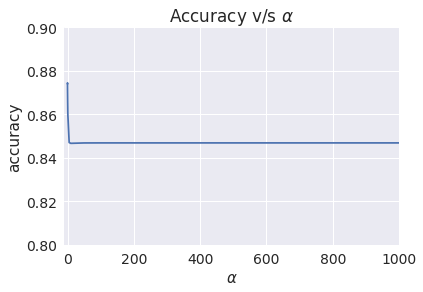

In [11]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])
plt.xlim(-10,1000)
plt.ylim(0.8,0.9)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y)
plt.show()

Accuracy on test set: 88.079%
Precision on test set: 0.677
Recall on test set: 0.606
F1-Score on test set: 0.640
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



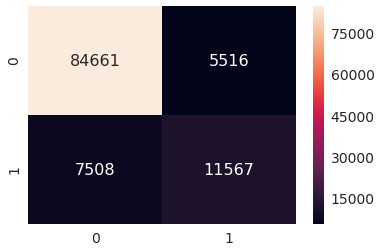

In [12]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB(alpha=0.001)
bnb.fit(X_train,y_train)
y_pred = bnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Multinomial Naive Bayes

In [13]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(mnb,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"NB/gsv_uni_mul")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   31.8s finished


Best HyperParameter:  {'alpha': 0.001}
Best Accuracy: 86.99%


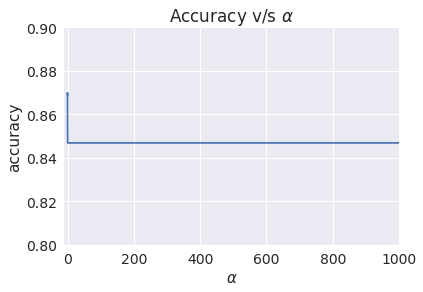

In [14]:
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])
plt.xlim(-10,1000)
plt.ylim(0.8,0.9)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y)
plt.show()

Accuracy on test set: 85.641%
Precision on test set: 0.917
Recall on test set: 0.195
F1-Score on test set: 0.322
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



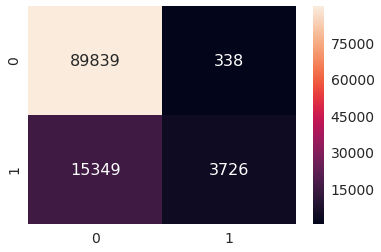

In [15]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=0.001)
mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Feature Importance[Top 25]

##### The coef_ attribute of MultinomialNB is a re-parameterization of the naive Bayes model as a linear classifier model. For a binary classification problems this is basically the log of the estimated probability of a feature given the positive class. It means that higher values mean more important features for the positive class.

In [16]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(uni_gram,bnb)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-17.4540	aaaa           				-0.6000	not            
	-17.4540	aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaseri				-0.9927	tast           
	-17.4540	aaaaaaaaaaaaaaaaaaaargh				-1.0046	like           
	-17.4540	aaaaaaaaagghh  				-1.2246	product        
	-17.4540	aaaaaaahhhhhh  				-1.3641	one            
	-17.4540	aaaaaah        				-1.4248	would          
	-17.4540	aaaaaahhh      				-1.4770	tri            
	-17.4540	aaaaaahhhhten  				-1.5611	flavor         
	-17.4540	aaaaaawwwwwwwwww				-1.5682	good           
	-17.4540	aaaaah         				-1.6188	buy            
	-17.4540	aaaaahhhhhhhhhhhhhhhhth				-1.6710	get            
	-17.4540	aaaaawsom      				-1.7154	use            
	-17.4540	aaaah          				-1.7735	dont           
	-17.4540	aaaahhhhhh     				-1.8378	even           
	-17.4540	aaaallll       				-1.8560	order          
	-17.4540	aaaand         				-1.

### bi-gram

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

#taking one words and two consecutive words together
bi_gram = CountVectorizer(ngram_range=(1,2)) 
X_train = bi_gram.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = bi_gram.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (254919, 2642089)
Test Data Size:  (109252, 2642089)


In [18]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,7,6,5,4,2,1,0.5,0.1,0.05,0.01,0.005,0.001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"NB/gsv_bi")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs
Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:  5.3min finished


Best HyperParameter:  {'alpha': 0.001}
Best Accuracy: 88.95%


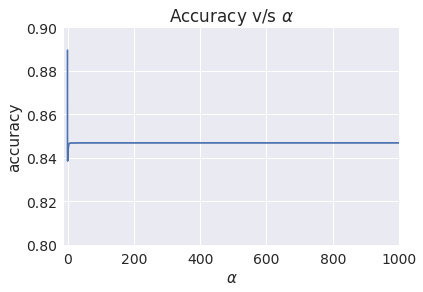

In [42]:
gsv = openfromfile("NB/gsv_bi")
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])
plt.xlim(-10,1000)
plt.ylim(0.8,0.9)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y)
plt.show()

Accuracy on test set: 88.633%
Precision on test set: 0.878
Recall on test set: 0.405
F1-Score on test set: 0.554
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



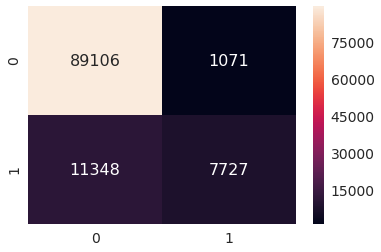

In [19]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB(alpha=0.001)
bnb.fit(X_train,y_train)
y_pred = bnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Multinomial Naive Bayes

In [20]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(mnb,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"NB/gsv_bi_mul")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.11 µs
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.6min finished


Best HyperParameter:  {'alpha': 0.005}
Best Accuracy: 89.78%


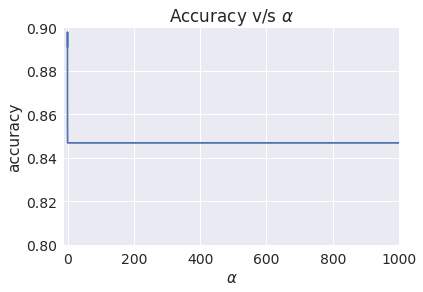

In [43]:
gsv = openfromfile("NB/gsv_bi_mul")
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])
plt.xlim(-10,1000)
plt.ylim(0.8,0.9)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y)
plt.show()

Accuracy on test set: 89.530%
Precision on test set: 0.921
Recall on test set: 0.438
F1-Score on test set: 0.594
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



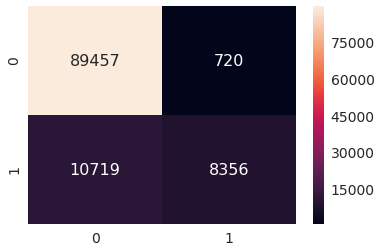

In [41]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=0.005)
mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Feature Importance[Top 25]

In [22]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(bi_gram,bnb)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-17.4540	aa pleas       				-0.6000	not            
	-17.4540	aa state       				-0.9927	tast           
	-17.4540	aaa aaa        				-1.0046	like           
	-17.4540	aaa condit     				-1.2246	product        
	-17.4540	aaa magazin    				-1.3641	one            
	-17.4540	aaa perfect    				-1.4248	would          
	-17.4540	aaa plus       				-1.4770	tri            
	-17.4540	aaa spelt      				-1.5611	flavor         
	-17.4540	aaa tue        				-1.5682	good           
	-17.4540	aaaa           				-1.6188	buy            
	-17.4540	aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaseri				-1.6710	get            
	-17.4540	aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaseri good				-1.7154	use            
	-17.4540	aaaaaaaaaaaaaaaaaaaargh				-1.7735	dont           
	-17.4540	aaaaaaaaaaaaaaaaaaaargh wait				-1.8378	even           
	-17.4540	aaaaaaaaagghh  				-1.8560	order 

# tf-idf


![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/01/11181616/image-4.png)

In [23]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

#Breaking into Train and test
X_train, X_test, y_train, y_test = train_test_split(df_sample['CleanedText'].values,df_sample['Score'].values,test_size=0.3,shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (254919, 2642089)
Test Data Size:  (109252, 2642089)
CPU times: user 58.1 s, sys: 584 ms, total: 58.7 s
Wall time: 58.7 s


In [24]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
param_grid = {'alpha':[1000,500,100,50,10,7,6,5,4,2,1,0.5,0.1,0.05,0.01,0.005,0.001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"NB/gsv_tfidf")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.63 µs
Fitting 10 folds for each of 17 candidates, totalling 170 fits


[Parallel(n_jobs=1)]: Done 170 out of 170 | elapsed:  5.2min finished


Best HyperParameter:  {'alpha': 0.001}
Best Accuracy: 88.95%


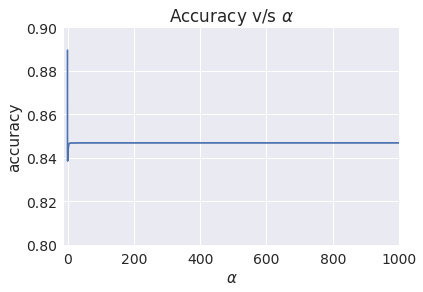

In [44]:
gsv = openfromfile("NB/gsv_tfidf")
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])
plt.xlim(-10,1000)
plt.ylim(0.8,0.9)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y)
plt.show()

Accuracy on test set: 88.633%
Precision on test set: 0.878
Recall on test set: 0.405
F1-Score on test set: 0.554
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



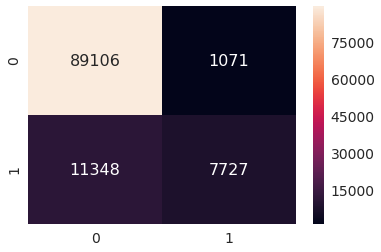

In [25]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB(alpha=0.001)
bnb.fit(X_train,y_train)
y_pred = bnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

### Multinomial Naive Bayes

In [26]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
param_grid = {'alpha':[1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(mnb,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"NB/gsv_tfidf_mul")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs
Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.5min finished


Best HyperParameter:  {'alpha': 0.05}
Best Accuracy: 88.06%


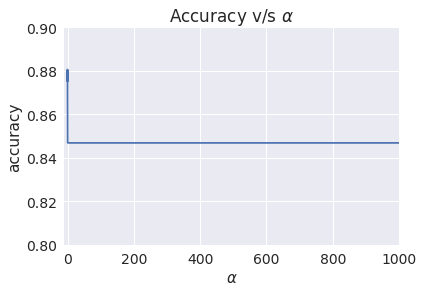

In [45]:
gsv = openfromfile("NB/gsv_tfidf_mul")
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])
plt.xlim(-10,1000)
plt.ylim(0.8,0.9)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y)
plt.show()

Accuracy on test set: 88.203%
Precision on test set: 0.938
Recall on test set: 0.347
F1-Score on test set: 0.507
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



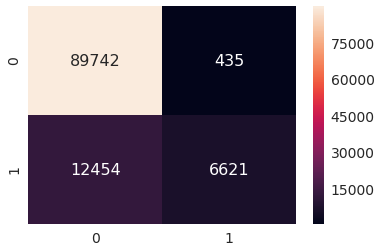

In [27]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=0.05)
mnb.fit(X_train,y_train)
y_pred = mnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

#### Feature Importance[Top 25]

In [28]:
def show_most_informative_features(vectorizer, clf, n=25):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\t\tPositive\t\t\t\t\t\tNegative")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(tfidf,bnb)
#Code Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Positive						Negative
________________________________________________________________________________________________
	-17.4540	aa pleas       				-0.6000	not            
	-17.4540	aa state       				-0.9927	tast           
	-17.4540	aaa aaa        				-1.0046	like           
	-17.4540	aaa condit     				-1.2246	product        
	-17.4540	aaa magazin    				-1.3641	one            
	-17.4540	aaa perfect    				-1.4248	would          
	-17.4540	aaa plus       				-1.4770	tri            
	-17.4540	aaa spelt      				-1.5611	flavor         
	-17.4540	aaa tue        				-1.5682	good           
	-17.4540	aaaa           				-1.6188	buy            
	-17.4540	aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaseri				-1.6710	get            
	-17.4540	aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaseri good				-1.7154	use            
	-17.4540	aaaaaaaaaaaaaaaaaaaargh				-1.7735	dont           
	-17.4540	aaaaaaaaaaaaaaaaaaaargh wait				-1.8378	even           
	-17.4540	aaaaaaaaagghh  				-1.8560	order 

## Gensim
Gensim is a robust open-source vector space modeling and topic modeling toolkit implemented in Python. It uses NumPy, SciPy and optionally Cython for performance. Gensim is specifically designed to handle large text collections, using data streaming and efficient incremental algorithms, which differentiates it from most other scientific software packages that only target batch and in-memory processing.

## Word2Vec
[Refer Docs] :https://radimrehurek.com/gensim/models/word2vec.html 

In [29]:
from gensim.models import KeyedVectors

#Loading the model from file in the disk
w2vec_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True) 

In [30]:
w2v_vocub = w2vec_model.wv.vocab
len(w2v_vocub)

3000000

## Avg Word2Vec
* One of the most naive but good ways to convert a sentence into a vector
* Convert all the words to vectors and then just take the avg of the vectors the resulting vector represent the sentence 

In [31]:
%%time
avg_vec_google = [] #List to store all the avg w2vec's 
# no_datapoints = 364170
# sample_cols = random.sample(range(1, no_datapoints), 20001)
for sent in df_sample['CleanedText_NoStem']:
    cnt = 0 #to count no of words in each reviews
    sent_vec = np.zeros(300) #Initializing with zeroes
#     print("sent:",sent) 
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
#             print("wvec:",wvec)
            sent_vec += wvec #Adding the vectors
#             print("sent_vec:",sent_vec)
            cnt += 1
        except: 
            pass #When the word is not in the dictionary then do nothing  
#     print(sent_vec)
    sent_vec /= cnt #Taking average of vectors sum of the particular review
#     print("avg_vec:",sent_vec)
    avg_vec_google.append(sent_vec) #Storing the avg w2vec's for each review
#     print("*******************************************************************")
# print(avg_vec_google)
avg_vec_google = np.array(avg_vec_google)

CPU times: user 3min 15s, sys: 616 ms, total: 3min 15s
Wall time: 3min 15s


In [32]:
np.isnan(avg_vec_google).any()

True

In [33]:
mask = ~np.any(np.isnan(avg_vec_google), axis=1)
# print(mask)
avg_vec_google_new = avg_vec_google[mask]
df_sample_new = df_sample['Score'][mask]
print(avg_vec_google_new.shape)
print(df_sample_new.shape)

(364167, 300)
(364167,)


In [34]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

avg_vec_norm = preprocessing.normalize(avg_vec_google_new)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(avg_vec_norm,df_sample_new.values,test_size=0.3,shuffle=False)

In [35]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import TimeSeriesSplit

bnb = BernoulliNB()
param_grid = {'alpha':[10000,7500,5000,2500,1000,500,100,50,10,7,6,5,4,2,1,0.5,0.1,0.05,0.01,0.005,0.001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"NB/gsv_aw2v")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs
Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:  6.1min finished


Best HyperParameter:  {'alpha': 10000}
Best Accuracy: 84.56%


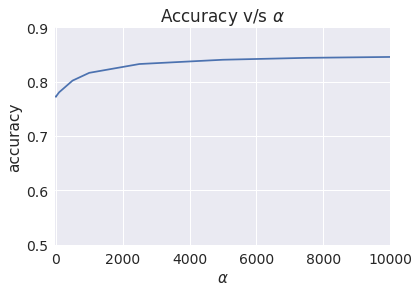

In [51]:
gsv = openfromfile("NB/gsv_aw2v")
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])
plt.xlim(-10,10000)
plt.ylim(0.5,0.9)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y)
plt.show()

Accuracy on test set: 82.533%
Precision on test set: 0.250
Recall on test set: 0.000
F1-Score on test set: 0.000
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



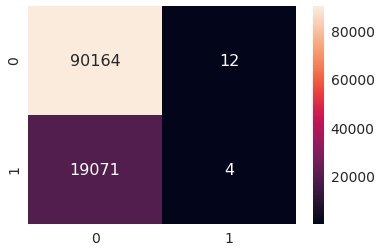

In [36]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB(alpha=10000)
bnb.fit(X_train,y_train)
y_pred = bnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Tf-idf W2Vec
* Another way to covert sentence into vectors
* Take weighted sum of the vectors divided by the sum of all the tfidf's 
<br>i.e. (tfidf(word) x w2v(word))/sum(tfidf's)

In [11]:
%%time
###tf-idf with No Stemming
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.sparse import vstack

#Taking sample of only 25k points as it takes a huge amount of time ot compute 
n_samples = 25000
df_sample_new = df_sample.sample(n_samples)
X_train, X_test, y_train, y_test = train_test_split(df_sample_new['CleanedText_NoStem'].values,df_sample_new['Score'].values,test_size=0.3,shuffle=False)

tfidf = TfidfVectorizer(ngram_range=(1,2)) #Using bi-grams
tfidf_vec_train = tfidf.fit_transform(X_train)
tfidf_vec_test = tfidf.transform(X_test)
print(tfidf_vec_train.shape)
print(tfidf_vec_test.shape)

#Concatenating sparse matrix vertically
tfidf_vec_new = vstack((tfidf_vec_train,tfidf_vec_test))
print(tfidf_vec.shape)
features = tfidf.get_feature_names()
savetofile(df_sample_new,"df_sample_new_tfidfw2vec")

(25000, 589499)
CPU times: user 6.15 s, sys: 16 ms, total: 6.16 s
Wall time: 6.16 s


In [ ]:
%%time
tfidf_w2v_vec_google = []
review = 0

for sent in df_sample_new['CleanedText_NoStem'].values:
    cnt = 0 
    weighted_sum  = 0
    sent_vec = np.zeros(300)
    sent = sent.decode("utf-8") 
    for word in sent.split():
        try:
#             print(word)
            wvec = w2vec_model.wv[word] #Vector of each using w2v model
#             print("w2vec:",wvec)
#             print("tfidf:",tfidf_vec_ns[review,features.index(word)])
            tfidf_vec = tfidf_vec_new[review,features.index(word)]
            sent_vec += (wvec * tfidf_vec)
            weighted_sum += tfidf_vec
        except:
#             print(review)
            pass
    sent_vec /= weighted_sum
#     print(sent_vec)
    tfidf_w2v_vec_google.append(sent_vec)
    review += 1
tfidf_w2v_vec_google = np.array(tfidf_w2v_vec_google)
savetofile(tfidf_w2v_vec_google,"tfidf_w2v_vec_google")

In [37]:
#Precomputed File
tfidf_w2v_vec_google = openfromfile("tfidf_w2v_vec_google")
#Loading the same samples as using precomuted file
df_sample_new = openfromfile("df_sample_new_tfidfw2vec")

In [38]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

tfidfw2v_vecs_norm = preprocessing.normalize(tfidf_w2v_vec_google)

#Not shuffling the data as we want it on time basis
X_train, X_test, y_train, y_test = train_test_split(tfidfw2v_vecs_norm,df_sample_new['Score'].values,test_size=0.3,shuffle=False)

In [39]:
%time
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import TimeSeriesSplit

bnb = BernoulliNB()
param_grid = {'alpha':[100000,75000,50000,25000,10000,7500,5000,2500,1000,500,100,50,10,7,6,5,4,2,1,0.5,0.1,0.05,0.01,0.005,0.001]} #params we need to try on classifier
tscv = TimeSeriesSplit(n_splits=10) #For time based splitting
gsv = GridSearchCV(bnb,param_grid,cv=tscv,verbose=1)
gsv.fit(X_train,y_train)
savetofile(gsv,"NB/gsv_tfidfaw2v")
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 19.3 µs
Fitting 10 folds for each of 25 candidates, totalling 250 fits
Best HyperParameter:  {'alpha': 100000}
Best Accuracy: 84.09%


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   27.0s finished


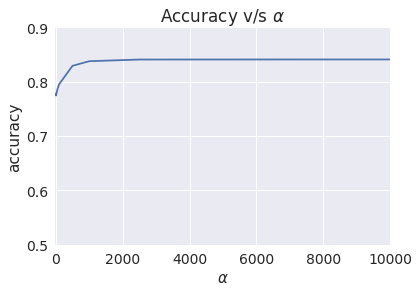

In [52]:
gsv = openfromfile("NB/gsv_tfidfaw2v")
x=[]
y=[]
for a in gsv.grid_scores_:
    x.append(a[0]['alpha']) 
    y.append(a[1])
plt.xlim(-10,10000)
plt.ylim(0.5,0.9)
plt.xlabel(r"$\alpha$",fontsize=15)
plt.ylabel("accuracy")
plt.title(r'Accuracy v/s $\alpha$')
plt.plot(x,y)
plt.show()

Accuracy on test set: 83.853%
Precision on test set: 0.000
Recall on test set: 0.000
F1-Score on test set: 0.000
Confusion Matrix of test set:
 [ [TN  FP]
 [FN TP] ]



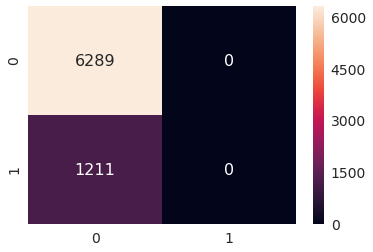

In [78]:
#Testing Accuracy on Test data
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB(alpha=100000)
bnb.fit(X_train,y_train)
y_pred = bnb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
print("Confusion Matrix of test set:\n [ [TN  FP]\n [FN TP] ]\n")
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(2),range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')

## Performance Table

![image](https://image.ibb.co/mYmrZJ/3_Naive_Bayes.png)

## Conclusions<br>
1. The best thing about Naive Bayes it much quicker than algorithms amazingly fast training times<br>
2. Best Models are Bi-Gram with accuracy of 89.53% and precision of 0.594<br>
3. Multinomial Naive Bayes does not work with negative values<br>
4. Naive Bayes fails miserably with featurization of Word2Vec and tfidf Word2Vec as Word2Vec feature are completely dependent while Naive Bayes is based on assumption of feature independence<br>

